# Evolutionary parameter search with a single neural mass model
This notebook provides a simple example for the use of the evolutionary optimization framework builtin to the library. Under the hood, the implementation of the evolutionary algorithm is powered by `deap` and `pypet` cares about the parallelization and storage of the simulation data for us.

We want to optimize for a simple target, namely finding a parameter configuration that prouces actiity with a peak power frequency spectrum at 25 Hz.

In [14]:
# change into root directory to the project
import os
if os.getcwd().split("/")[-1] == "examples":
    print("chdir")
    os.chdir('..')

In [2]:
import logging
#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)

%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from neurolib.models.aln import ALNModel
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.evolution import Evolution
import neurolib.utils.functions as func

#import neurolib. as du

# sett dpi for notebooks on server
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['image.cmap'] = 'plasma'

/Users/caglar/anaconda/lib/python3.7/site-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


## Model definition

In [4]:
aln = ALNModel()
aln.run()

In [5]:
aln.outputs

{'t': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.9997e+03, 1.9998e+03,
        1.9999e+03]),
 'rates_exc': array([[5.31265544, 5.31265544, 5.31265544, ..., 5.26771554, 5.18859683,
         5.10831371]]),
 'rates_inh': array([[4.92837804, 4.92837804, 4.92837804, ..., 9.2707452 , 9.30451598,
         9.33616944]])}

In [6]:
# Here we define our evaluation function. This function will
# be called reapedly and perform a single simulation. The object
# that is passed to the function, `traj`, is a pypet trajectory
# and serves as a "bridge" to load the parameter set of this 
# particular trajectory and execute a run.
# Then the power spectrum of the run is computed and its maximum
# is fitted to the target of 25 Hz peak frequency.
def evaluateSimulation(traj):
    # The trajectory id is provided as an attribute
    rid = traj.id
    logging.info("Running run id {}".format(rid))
    # this function provides the a model with the partuclar
    # parameter set for this given run
    model = evolution.getModelFromTraj(traj)
    # parameters can also be modified after loading
    model.params['dt'] = 0.1
    model.params['duration'] = 2*1000.
    # and the simulation is run
    model.run()
    
    # compute power spectrum
    frs, powers = func.getPowerSpectrum(model.rates_exc[:, -int(1000/model.params['dt']):], dt=model.params['dt'])
    # find the peak frequency
    domfr = frs[np.argmax(powers)] 
    # fitness evaluation: let's try to find a 25 Hz oscillation
    fitness = abs(domfr - 25) 
    # deap needs a fitness *tuple*!
    fitness_tuple = ()
    # more fitness values could be added
    fitness_tuple += (fitness,)
    # we need to return the fitness tuple and the outputs of the model
    return fitness_tuple, model.outputs

## Initialize and run evolution

The evolutionary algorithm tries to find the optimal parameter set that will maximize (or minimize) a certain fitness function. 

This achieved by seeding an initial population of size `POP_INIT_SIZE` that is randomly initiated in the parameter space `parameterSpace`. INIT: After simulating the initial population using `evalFunction`, only a subset of the individuals is kept, defined by `POP_SIZE`. 

START: Members of the remaining population are chosen based on their fitness (using rank selection) to mate and produce `offspring`. These `offspring` have parameters that are drawn from a normal distribution defined by the mean of the parameters between the two parents. Then the `offspring` population is evaluated and the process loops back to START: 

This process is repeated for `NGEN` generations.

In [7]:
# Here we define the parameters and the range in which we want
# to perform the evolutionary optimization.
# Create a `ParameterSpace` 
pars = ParameterSpace(['mue_ext_mean', 'mui_ext_mean'], [[0.0, 4.0], [0.0, 4.0]])
# Iitialize evolution with
# :evaluateSimulation: The function that returns a fitness, 
# :pars: The parameter space and its boundaries to optimize
# :model: The model that should be passed to the evaluation function
# :weightList: A list of optimization weights for the `fitness_tuple`,
#              positive values will lead to a maximization, negative 
#              values to a minimzation. The length of this list must
#              be the same as the length of the `fitness_tuple`.
# 
# :POP_INIT_SIZE: The size of the initial population that will be 
#              randomly sampled in the parameter space `pars`.
#              Should be higher than POP_SIZE. 50-200 might be a good
#              range to start experimenting with.
# :POP_SIZE: Size of the population that should evolve. Must be an
#              even number. 20-100 might be a good range to start with.
# :NGEN: Number of generations to simulate the evolution for. A good
#              range to start with might be 20-100.

evolution = Evolution(evalFunction = evaluateSimulation, parameterSpace = pars, model = aln, weightList = [-1.0], POP_INIT_SIZE=6, POP_SIZE = 4, NGEN=3)
# Enabling `verbose = True` will print statistics and generate plots 
# of the current population for each generation.
evolution.run(verbose = False)

MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Evaluating initial population of size 6 ...
MainProcess pypet.trajectory.Trajectory INFO     Your trajectory has not been explored, yet. I will call `f_explore` instead.
MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2020-02-03-00H-26M-03S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2020-02-03-00H-26M-03S`.
MainProcess pypet.environment.Environment INFO     
*******************************************************

# Analysis

### Population

In [8]:
# the current population is always accesible via
pop = evolution.pop
# we can also use the functions registered to deap
# to select the best of the population:
best_10 = evolution.toolbox.selBest(pop, k=10)
# Remember, we performed a minimization so a fitness
# of 0 is optimal
print("Best individual", best_10[0], "fitness", best_10[0].fitness)

Best individual [3.644734684319668, 2.617852870277746, 1.3333333333333333, 1.3333333333333333] fitness (24.0,)


Parameters dictribution (Generation 2):
mue_ext_mean: 	 mean: 2.814,	 std: 0.5774
mui_ext_mean: 	 mean: 1.949,	 std: 0.6523
There are 4 valid individuals
Mean score across population: -2.4e+01


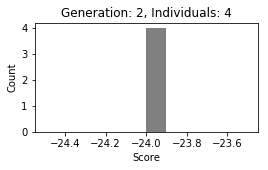

<Figure size 432x288 with 0 Axes>

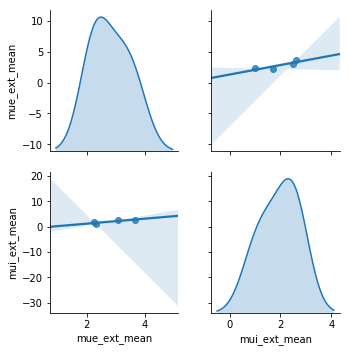

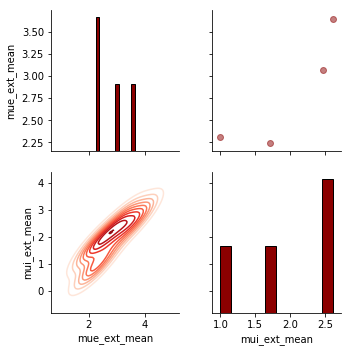

--------------------------
Best 20 individuals:
Printing 4 individuals
Individual 0 pars mue_ext_mean 3.645, mui_ext_mean 2.618
	Fitness values:  24.0
Individual 1 pars mue_ext_mean 2.307, mui_ext_mean 0.9892
	Fitness values:  24.0
Individual 2 pars mue_ext_mean 3.062, mui_ext_mean 2.476
	Fitness values:  24.0
Individual 3 pars mue_ext_mean 2.244, mui_ext_mean 1.714
	Fitness values:  24.0


In [9]:
# a sinple overview of the current population (in this case the 
# last one) is given via the `info()` method. This provides a 
# a histogram of the score (= mean fitness) and scatterplots
# and density estimates across orthogonal parameter space cross 
# sections.
evolution.info(plot=True)

### Load results from disk

In [10]:
# This will load results from disk in case the session is 
# started newly and the trajectory is not in memory
traj = evolution.loadResults()

MainProcess root INFO     Loading results from ./data/hdf/evolution.hdf
MainProcess root INFO     Analyzing trajectory results-2020-02-03-00H-26M-03S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/evolution.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2020-02-03-00H-26M-03S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `derived_parameters` in mode `1`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.


In [11]:
gens, all_scores = evolution.getScoresDuringEvolution()

Text(0, 0.5, 'Score')

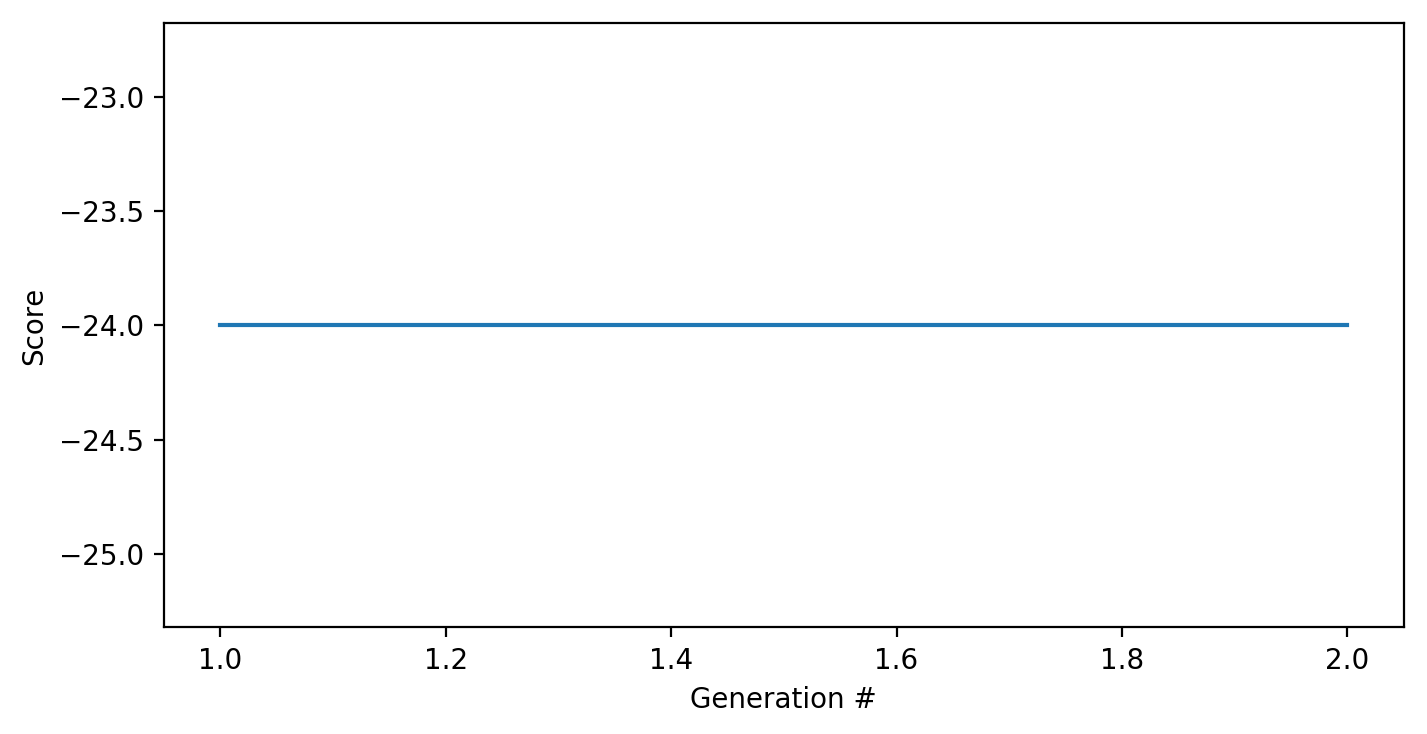

In [12]:
plt.figure(figsize=(8, 4), dpi=200)   
plt.plot(gens, np.nanmean(all_scores, axis=1))
plt.fill_between(gens, np.nanmin(all_scores, axis=1), np.nanmax(all_scores, axis=1), alpha=0.3)
plt.xlabel("Generation #")
plt.ylabel("Score")

In [13]:
# if we were lazy, we could just dump the whole evolution object into a file:
# import dill
# dill.dump(evolution, open("evolution.dill", "wb"))